In [ ]:
!pip install scikit-image
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score

In [ ]:
# Connect Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import zip libraries
import zipfile

In [ ]:
# Zip file

# Specify the zip file path
zip_file_path = "/content/gdrive/MyDrive/Project/train5.zip"

# Specify the directory where you want to extract the zip file in Google Drive
extract_dir = "/content/gdrive/MyDrive/Project/"

# Create the directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file to the specified directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


In [ ]:
# Set the extracted directories for training and validation data
train_data_dir = os.path.join(extract_dir, "train/train")
valid_data_dir = os.path.join(extract_dir, "train/valid")
test_data_dir = os.path.join(extract_dir, "train/test")

In [ ]:
# Image augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

In [ ]:
train_datagen = datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

val_datagen = datagen.flow_from_directory(
    valid_data_dir,
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

Found 1069 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [ ]:
# Load VGG16 base model and add custom classifier
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers except the last two layers of block5
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Compile model with a lower learning rate
model.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]

# Train model
history = model.fit(
    train_datagen,
    epochs=100,
    validation_data=val_datagen,
    callbacks=callbacks
)

58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
134/134 [==============================] - 976s 7s/step - loss: 1.3148 - accuracy: 0.7783 - val_loss: 2.5883 - val_accuracy: 0.5285
Epoch 2/100
134/134 [==============================] - 981s 7s/step - loss: 0.2099 - accuracy: 0.9495 - val_loss: 2.4352 - val_accuracy: 0.5440
Epoch 3/100
134/134 [==============================] - 952s 7s/step - loss: 0.1111 - accuracy: 0.9757 - val_loss: 4.0858 - val_accuracy: 0.5699
Epoch 4/100
134/134 [==============================] - 969s 7s/step - loss: 0.0319 - accuracy: 0.9888 - val_loss: 3.5828 - val_accuracy: 0.5803
Epoch 5/100
134/134 [==============================] - 970s 7s/step - loss: 0.0229 - accuracy: 0.9935 - val_loss: 4.5414 - val_accuracy: 0.5803
Epoch 6/100
134/134 [==============================] - 935s 7s/step - loss: 0.0218 - accuracy: 0.9953 - val_loss: 4.6974 - val_accuracy: 0.6114
Epoch 7/100
134/134 [==============================] - 970s 7s/step - loss: 0.0252 - accuracy: 0.9963 - val_loss: 6.7609 - val_accuracy:

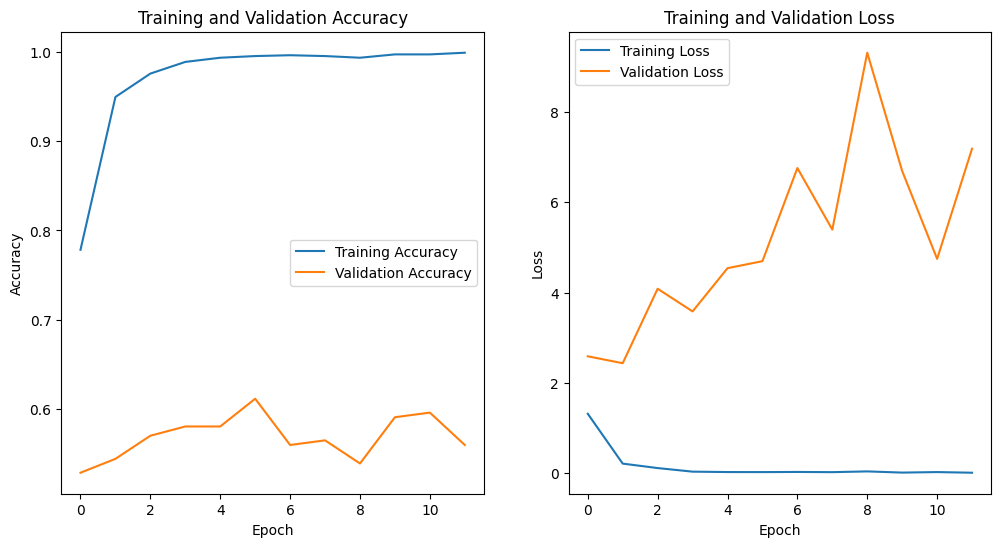

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate model
val_datagen.reset()
y_pred = model.predict(val_datagen, verbose=1)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = val_datagen.classes

25/25 [==============================] - 109s 4s/step


In [ ]:
# Calculate metrics
cm = confusion_matrix(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
accuracy = accuracy_score(y_true, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.5130
Precision: 0.6061
Recall (Sensitivity): 0.5217
Specificity: 0.5000


In [ ]:
model.save('my_model.h5')
from tensorflow.keras.models import load_model
loaded_model = load_model('my_model.h5')
from google.colab import files
files.download('my_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Add this function to convert one-hot encoded labels to class labels
def one_hot_to_class_labels(y_one_hot):
    return np.argmax(y_one_hot, axis=1)
# Create a test data generator without data augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(244, 244),
                                                  batch_size=8,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Important, do not shuffle

# Generate predictions on the test dataset
y_pred_one_hot = model.predict(test_generator)
y_pred = one_hot_to_class_labels(y_pred_one_hot)

# Get the true labels from the test generator
y_true = test_generator.classes

# Calculate classification metrics and print the report
class_names = ['Sweet Basil', 'Weed']
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

Found 122 images belonging to 2 classes.
16/16 [==============================] - 79s 5s/step
              precision    recall  f1-score   support

 Sweet Basil       0.20      1.00      0.33        24
        Weed       0.00      0.00      0.00        98

    accuracy                           0.20       122
   macro avg       0.10      0.50      0.16       122
weighted avg       0.04      0.20      0.06       122



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
image_path = "/content/sample_data/cropped_88_0.png"
image_path2 = "/content/sample_data/cropped_608_379.png"
# Prediction function
def predict_weed_positions(image_path, model, threshold=0.5):
    # Load and preprocess the image
    image = load_img(image_path, target_size=(224, 224))
    plt.imshow(image)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.0

    # Make predictions
    prediction = model.predict(image)

    # Determine if it's a weed or a crop
    if prediction < threshold:
        print(image_path)
        return "Sweet Basil"
    else:
        return "Weed"

# Replace this with the path to your input image
prediction = predict_weed_positions(image_path, model)
print("The input image contains:", prediction)

FileNotFoundError: ignored